In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 4 - Fall 2019
## Due 9 AM, Monday 11 Nov, 2019

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


**1.** Let's compare our dimensionalized, Barnes-style weight function to Gaussian function in `scipy.signal.windows.gaussian`. We understand its nondimensional frequency response quite well using theory from Koch, Trapp and Doswell, etc. However, the functions in `scipy.signal.windows.gaussian` control the cutoff in terms of the standard deviation. Since the functions are mathmatically equivalent, we should be able to reconcile them.

**a.** Using a data spacing of $\Delta=10$ m, what is the nyquist length scale $L_n$, and the spatial sampling frequency $f_s$ and nyquist $f_n$?


In [3]:
delta = 10
Ln = 2*delta
fs = 1 / delta
fn = 0.5 * fs
print(Ln, fs, fn, 1.0/Ln)

20 0.1 0.05 0.05


Let's assume we have $N=2047$ samples of data and sample at evenly spaced locations $x$ from $0$ to $(N-1)\Delta$.

To get a feel for what data looks like in the frequncy domain transform, let's look at a step function, a linear ramp, and a sine wave. The function provided below calcualtes the Fourier transform and plots its amplitude and phase response. You'll use this plot for the rest of the assignment.

**b.** There is no waviness to the ramp. Why is there amplitude at so many frequencies? 

**c.** When you run the code to show the FFT of the sine wave, why is there amplitude at more than a single frequency?

0.0 20460.0
4.885197850512946e-05 4.885197850512946e-05
-0.04997557401074744 0.04997557401074744 0.05
-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


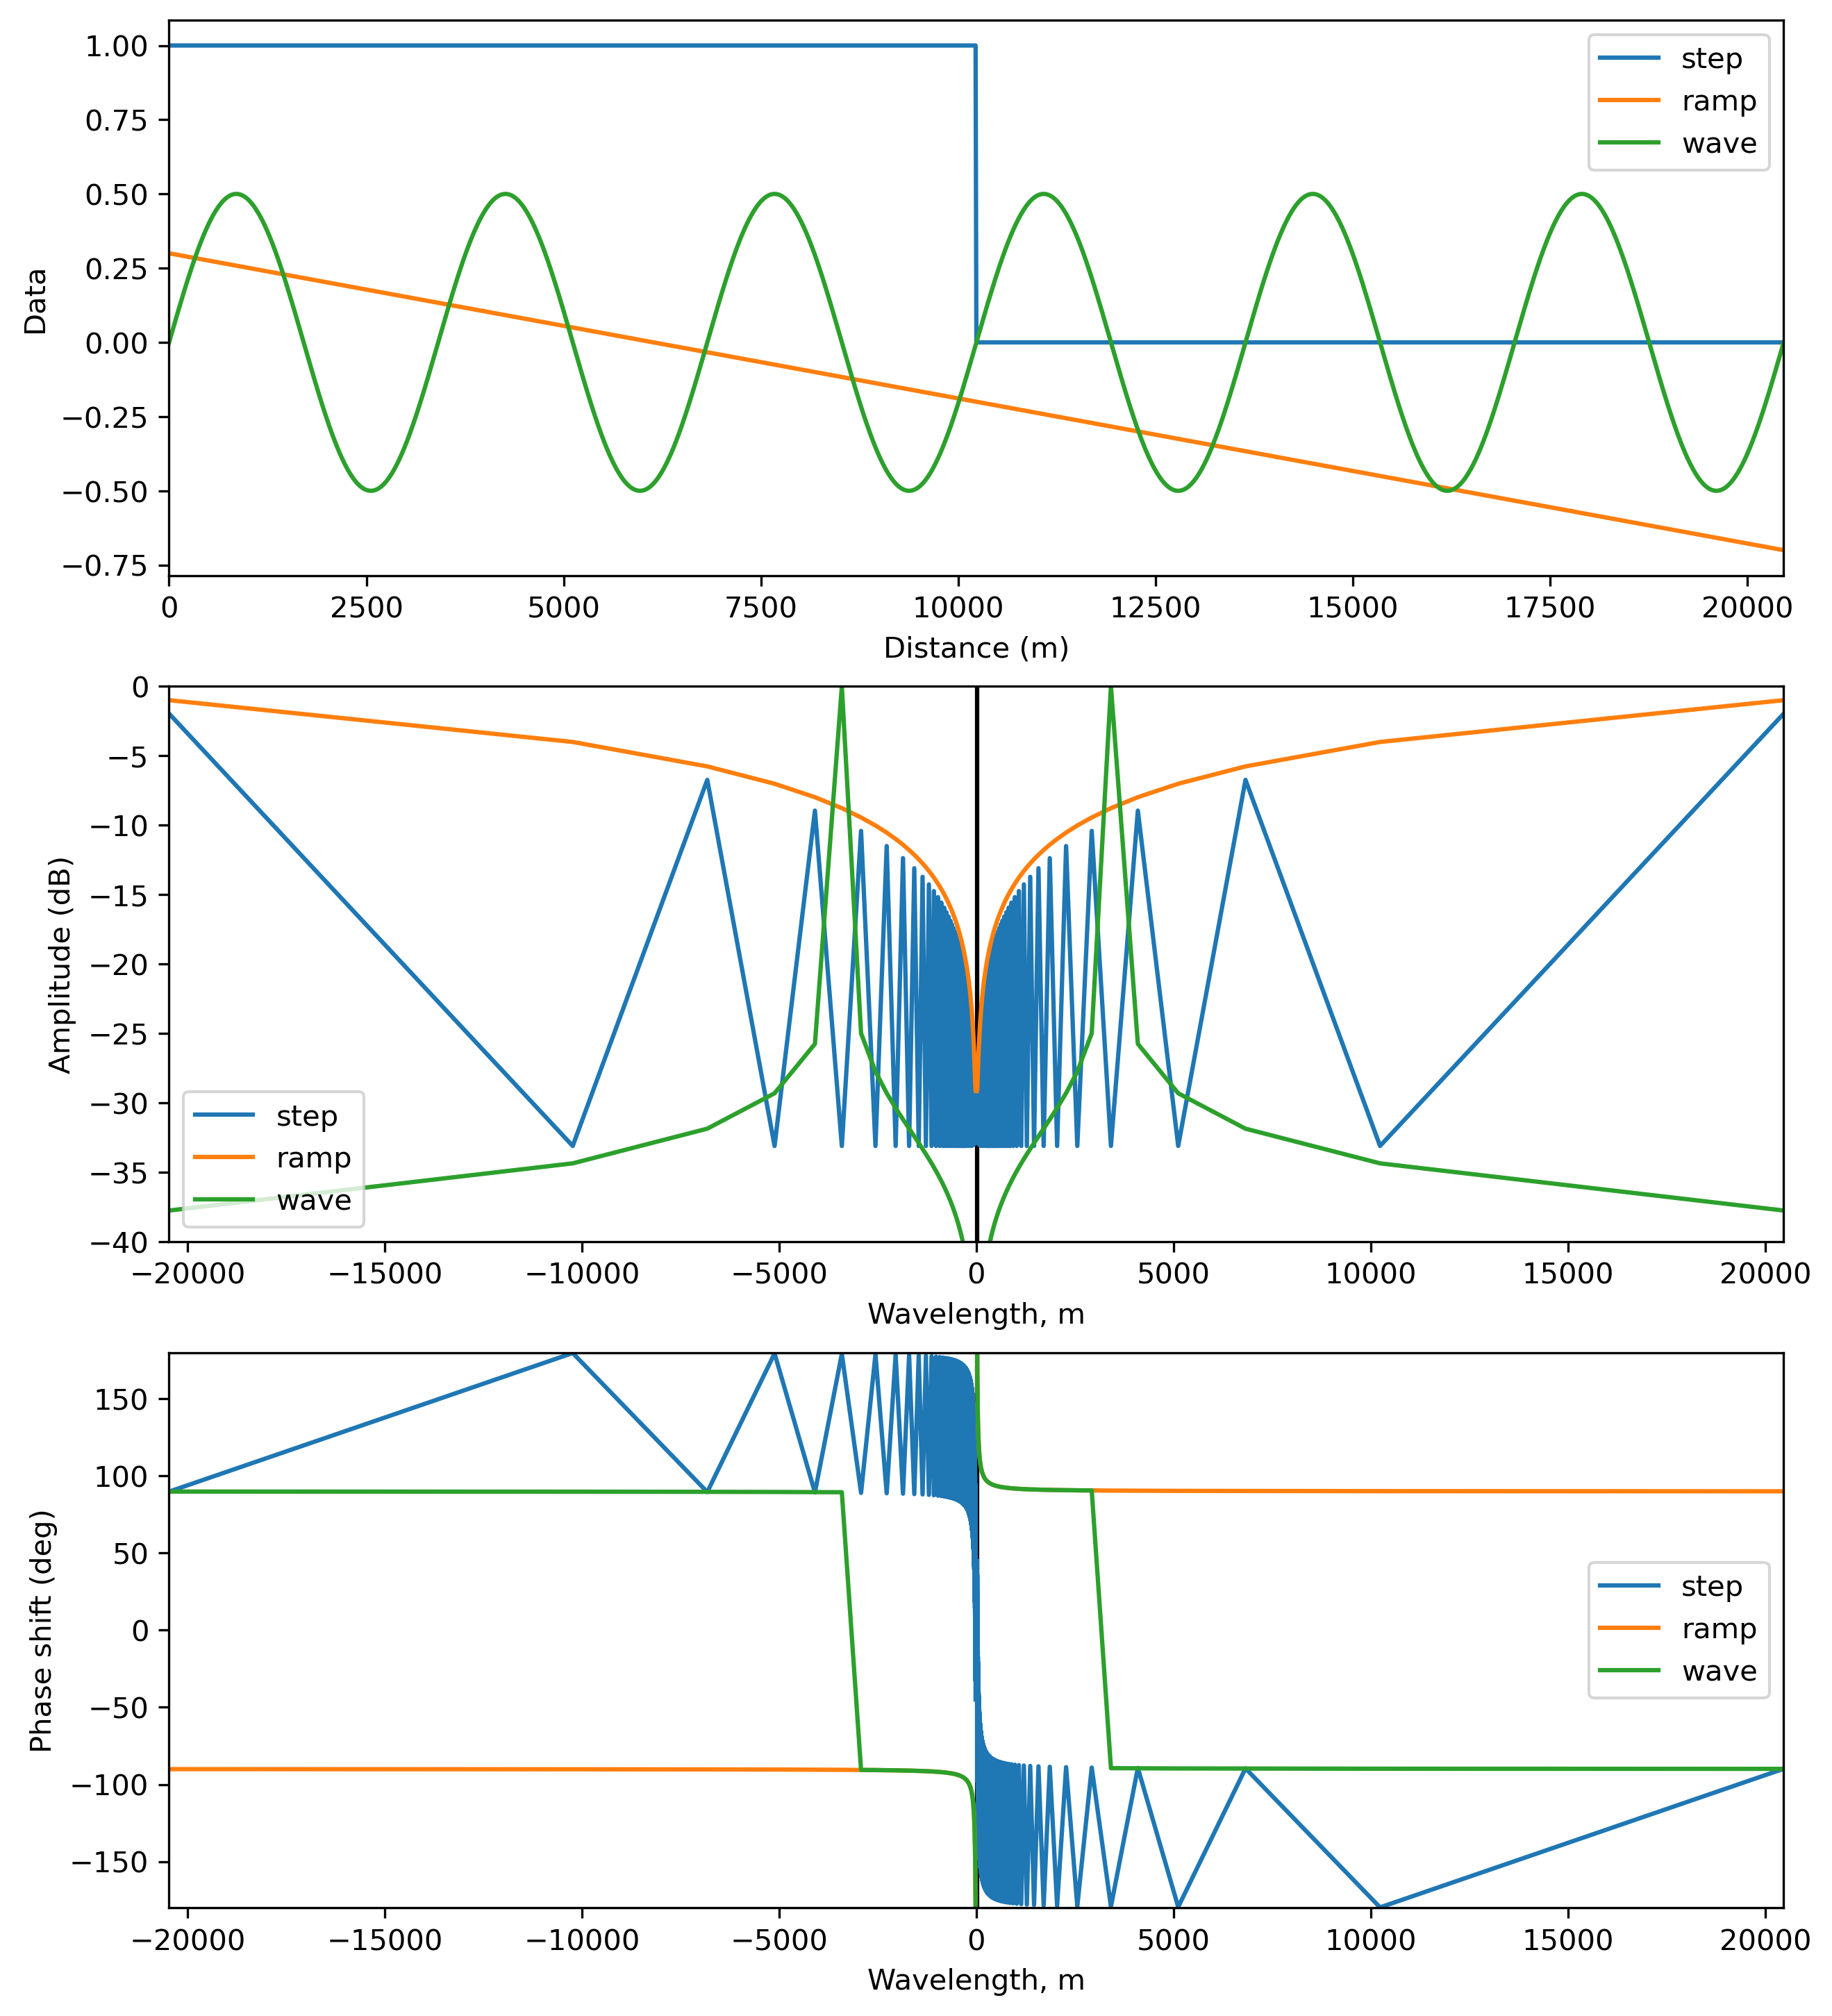

In [35]:
N = 2047
x = np.arange(N, dtype='f8')*delta
print(x.min(), x.max())

freqs = np.fft.fftfreq(N, delta)
df = freqs[1]-freqs[0]
# frequency interval is the same as that calculated theoretically from fs/N
print(df, fs/N)
# and so is the Nyquist
print(freqs.min(), freqs.max(), fn)

fftshift = np.fft.fftshift

def dB(a,base=1.0):
    return 10.0*np.log10(a/base)

def response_plot(signals, x, axs, freq, labels=None, wavelength=False, dB_amp=True):
    """ Signals is a tuple or list (or iterable) of signals.
    """
    if labels is None:
        labels = range(len(signals))
    ax_t, ax_f, ax_p = axs
    
    if wavelength:
        freqs = 1.0/freq
        freq_label = 'Wavelength, m' 
        fmin, fmax = np.nanmin(freqs), -np.nanmin(freqs)
        for ax in [ax_f, ax_p]: ax.axvline(Ln, color='k')
    else:
        freqs = freq
        freq_label = 'Spatial Frequency, m^-1' 
        fmin, fmax = np.nanmin(freqs), np.nanmax(freqs)
    print(fmin, fmax)
    
    for signal, label in zip(signals, labels):
        fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
        amplitude = np.abs(fftshift(fft_s))
        amplitude /= amplitude.max()
        phase = np.angle(fftshift(fft_s))
        
#         print(amplitude.max(), amplitude.min(), np.all(~np.isfinite(amplitude)))
#         print(phase.max(), phase.min())

        ax_t.plot(x, signal, label=label)
        ax_t.set_ylabel('Data')
        ax_t.set_xlabel('Distance (m)')
        ax_t.set_xlim(x.min(), x.max())
        john = ax_t.legend()

        if dB_amp:
            ax_f.plot(fftshift(freqs), dB(amplitude), label=label)
            ax_f.set_ylim(-40,0)
            ax_f.set_ylabel('Amplitude (dB)')
        else:
            ax_f.plot(fftshift(freqs), amplitude, label=label)
            ax_f.set_ylim(0,1)
            ax_f.set_ylabel('Amplitude (linear)')
        ax_f.set_xlim(fmin, fmax)
        ax_f.set_xlabel(freq_label)
        john = ax_f.legend()

        ax_p.plot(fftshift(freqs), np.degrees(phase), label=label)
        ax_p.set_ylim(-180,180)
        ax_p.set_xlim(fmin, fmax)
        ax_p.set_ylabel('Phase shift (deg)')
        ax_p.set_xlabel(freq_label)
        john = ax_p.legend()
        

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

step = np.zeros_like(x)
step[:int(N/2)] = 1.0

ramp = -x/x.max() + 0.3

wave = np.sin(x*12*np.pi/x.max())/2

signals = [step, ramp, wave]
labels = ['step', 'ramp', 'wave']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)

**b. There is amplitude at several frequencies for the reason that if you want to have a "linear" function on a fourier transform, you would just need to have a infinite number of tiny sinusodal waves that then make up a ramp function. Thus then you would have your multiple amplitudes.**

**c. So when you are completing an analysis of a sine wave when you take analysis points, no matter how many you take, the points would create several almost ramp functions, and not a smooth sine wave. This would then create several amplitudes at the same frequency.**

<span class="ecb">b. That's a good general description of FT. Why those specific frequencies? -2 c. Can only have one amplitude at the same frequency. It's interesting thinking about the finite sampling as a collection of ramps, though it would be possible to have a precise single peak if the sine frequency were an exact multiple of fs. -2 </span>

**2.** 

**a.** Implment the Barnes distance-dependent weighting function for $\kappa^* = 0.1$ and $0.5$. Center the weight function in the middle of the time series.

**b.** Simulate an artificial cutoff radius by setting any weights with value less than 0.1 to zero. This will give you four weight functions, two for each $\kappa^*$.

**c.** Use the `response_plot` function provided above to plot the four weight functions and their frequency domain response. Plot in wavelength mode, and zoom in to wavelengths between 0 and 200 (you don't need to show the negative wavelengths).

-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

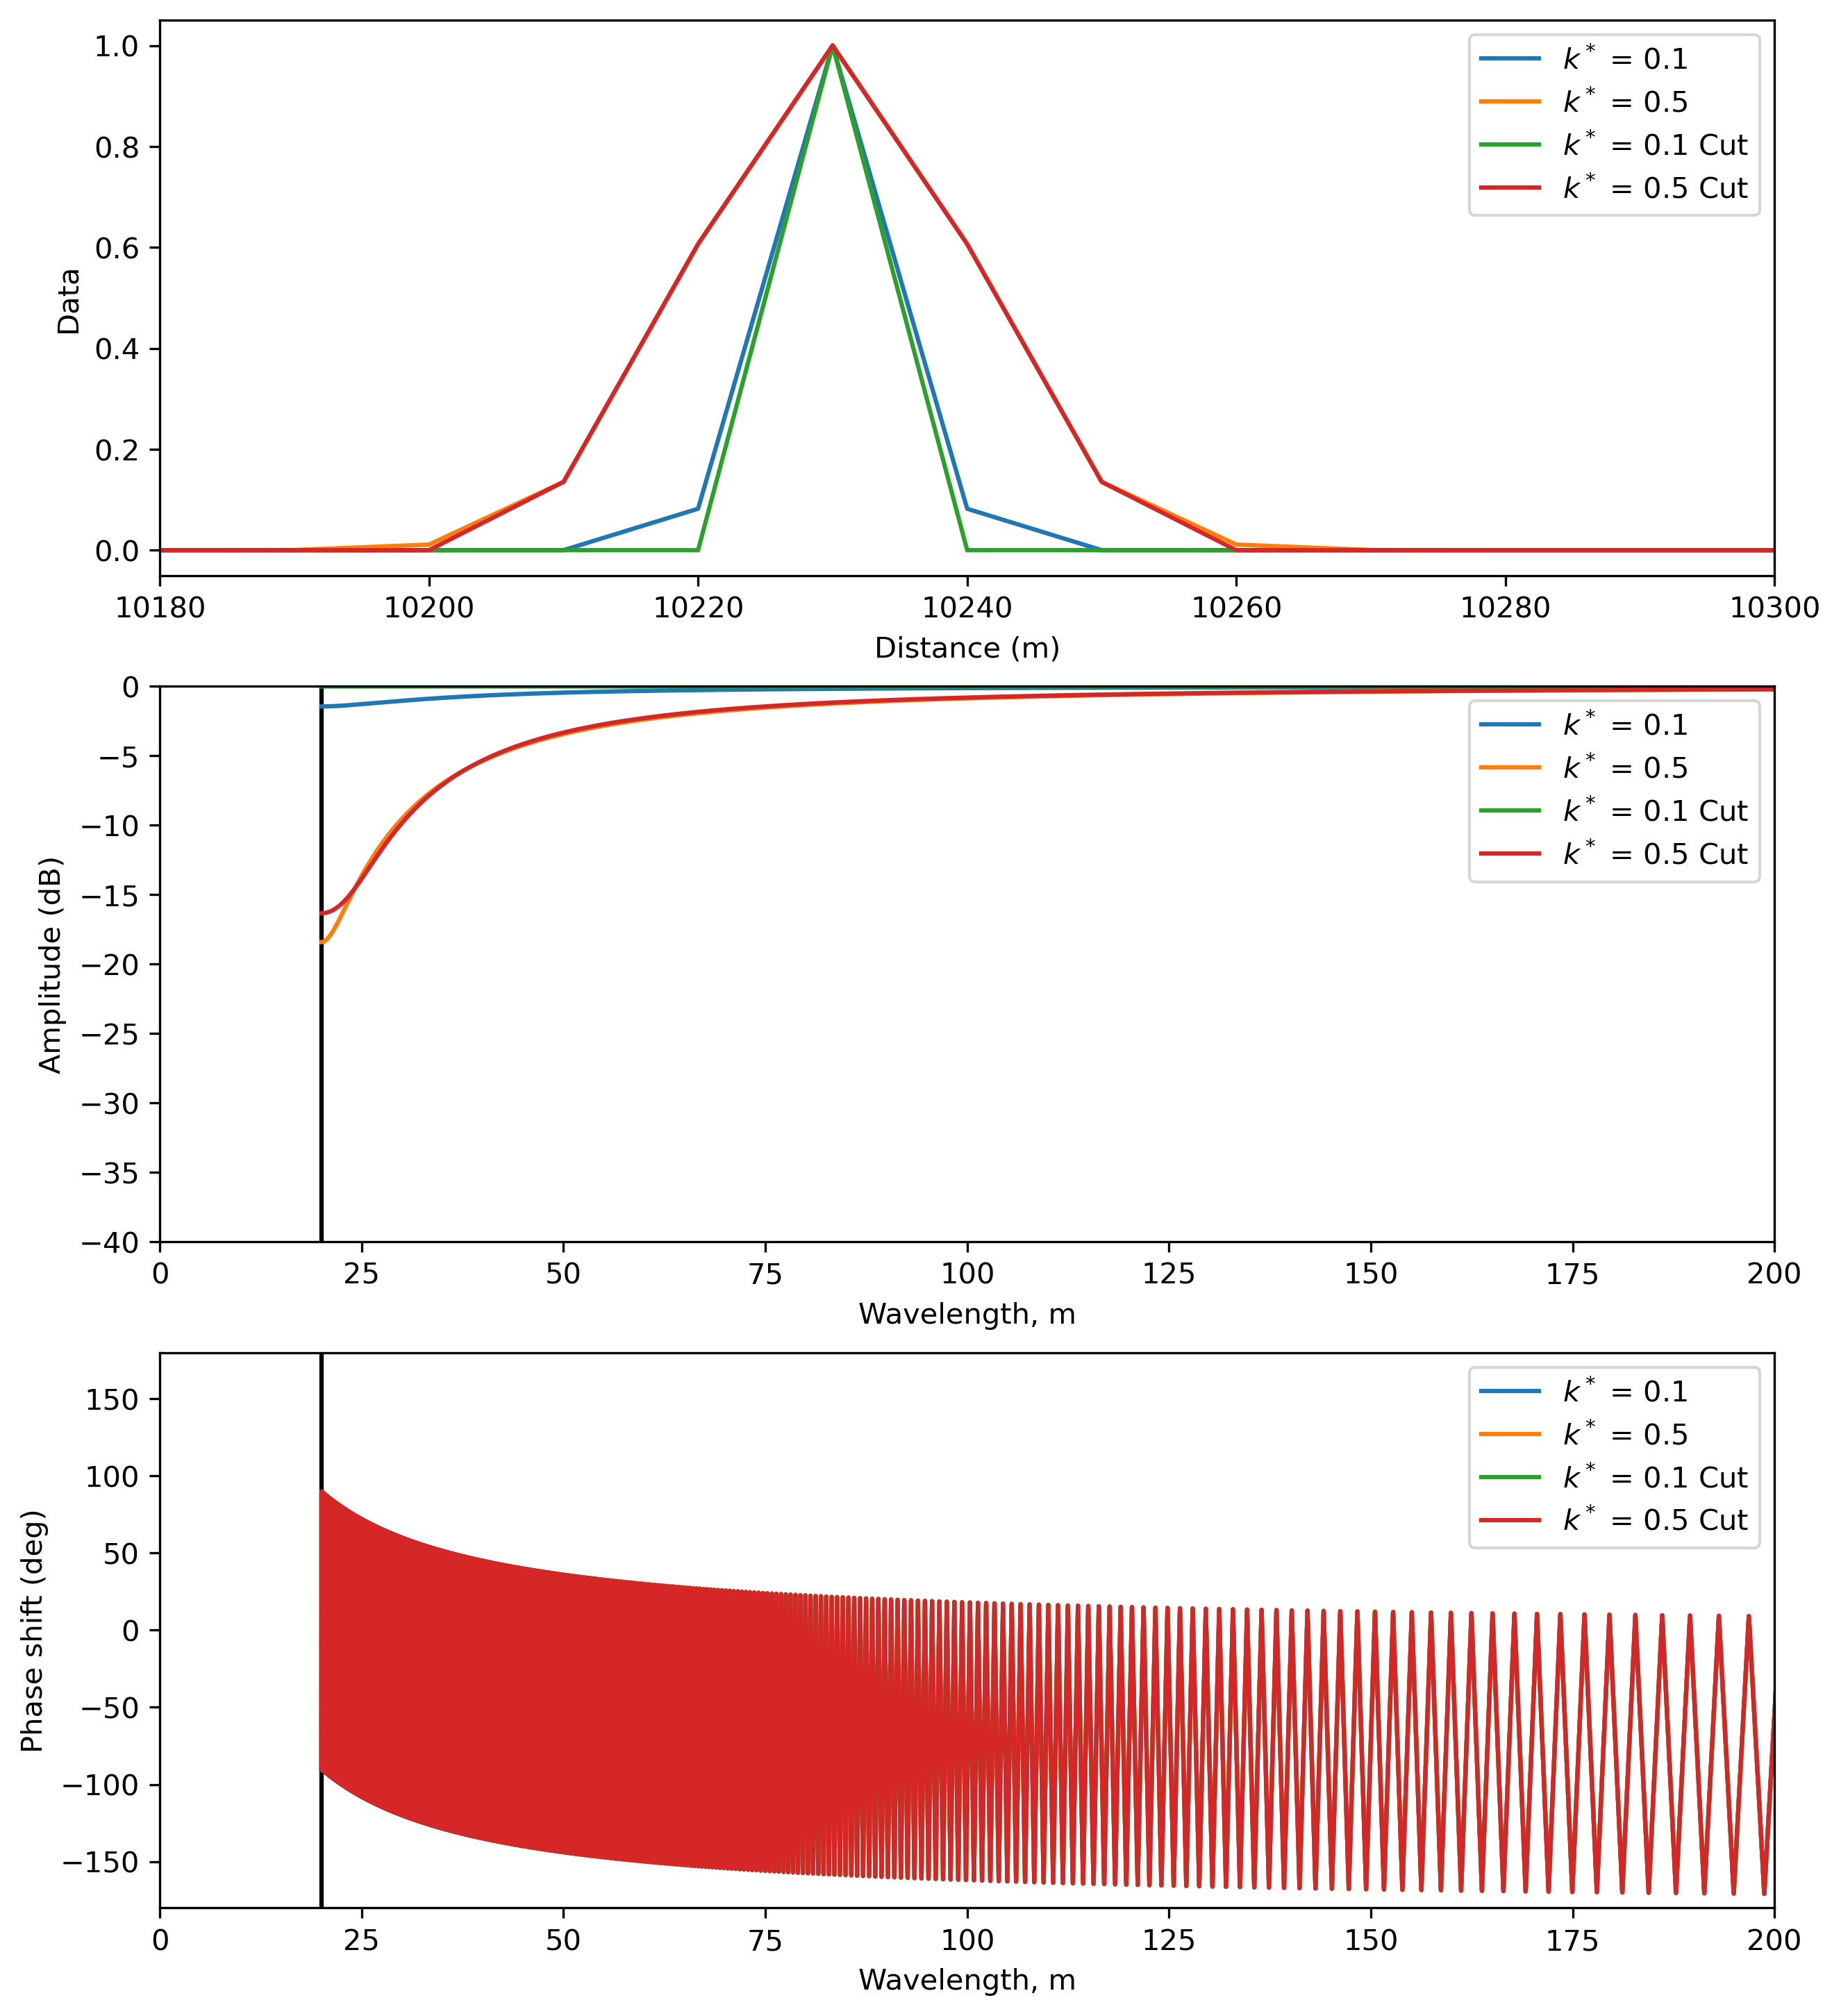

In [305]:
# Defining the barnes function
def barnes(r, k):
    r_ctr = np.max(r) / 2
    weight = np.exp((-(r - r_ctr)**2) / (4 * (delta**2) * k))
    return weight

from scipy.signal.windows import gaussian
weight_1 = barnes(x,k=0.1)
weight_5 = barnes(x,k=0.5)

weight_1_cut = np.where(weight_1 < 0.1,0,weight_1)
weight_5_cut = np.where(weight_5 < 0.1,0,weight_5)

# Plotting the figures and setting x limits for visability
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

weights = [weight_1, weight_5, weight_1_cut, weight_5_cut]
labels = ['$k^*$ = 0.1', '$k^*$ = 0.5', '$k^*$ = 0.1 Cut','$k^*$ = 0.5 Cut']

response_plot(weights[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(10180,10300)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**3.** Instead of weighting with the distance dependent weighting function you wrote, let's use the built-in Gaussian function: `from scipy.signal.windows import gaussian`. It is formulated in terms of the standard deviation. In lecture we derived the relationship $\sigma = \sqrt{2\kappa^*}$. 

Reproduce your plot above using the built-in Gaussian window (weight) function.

-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

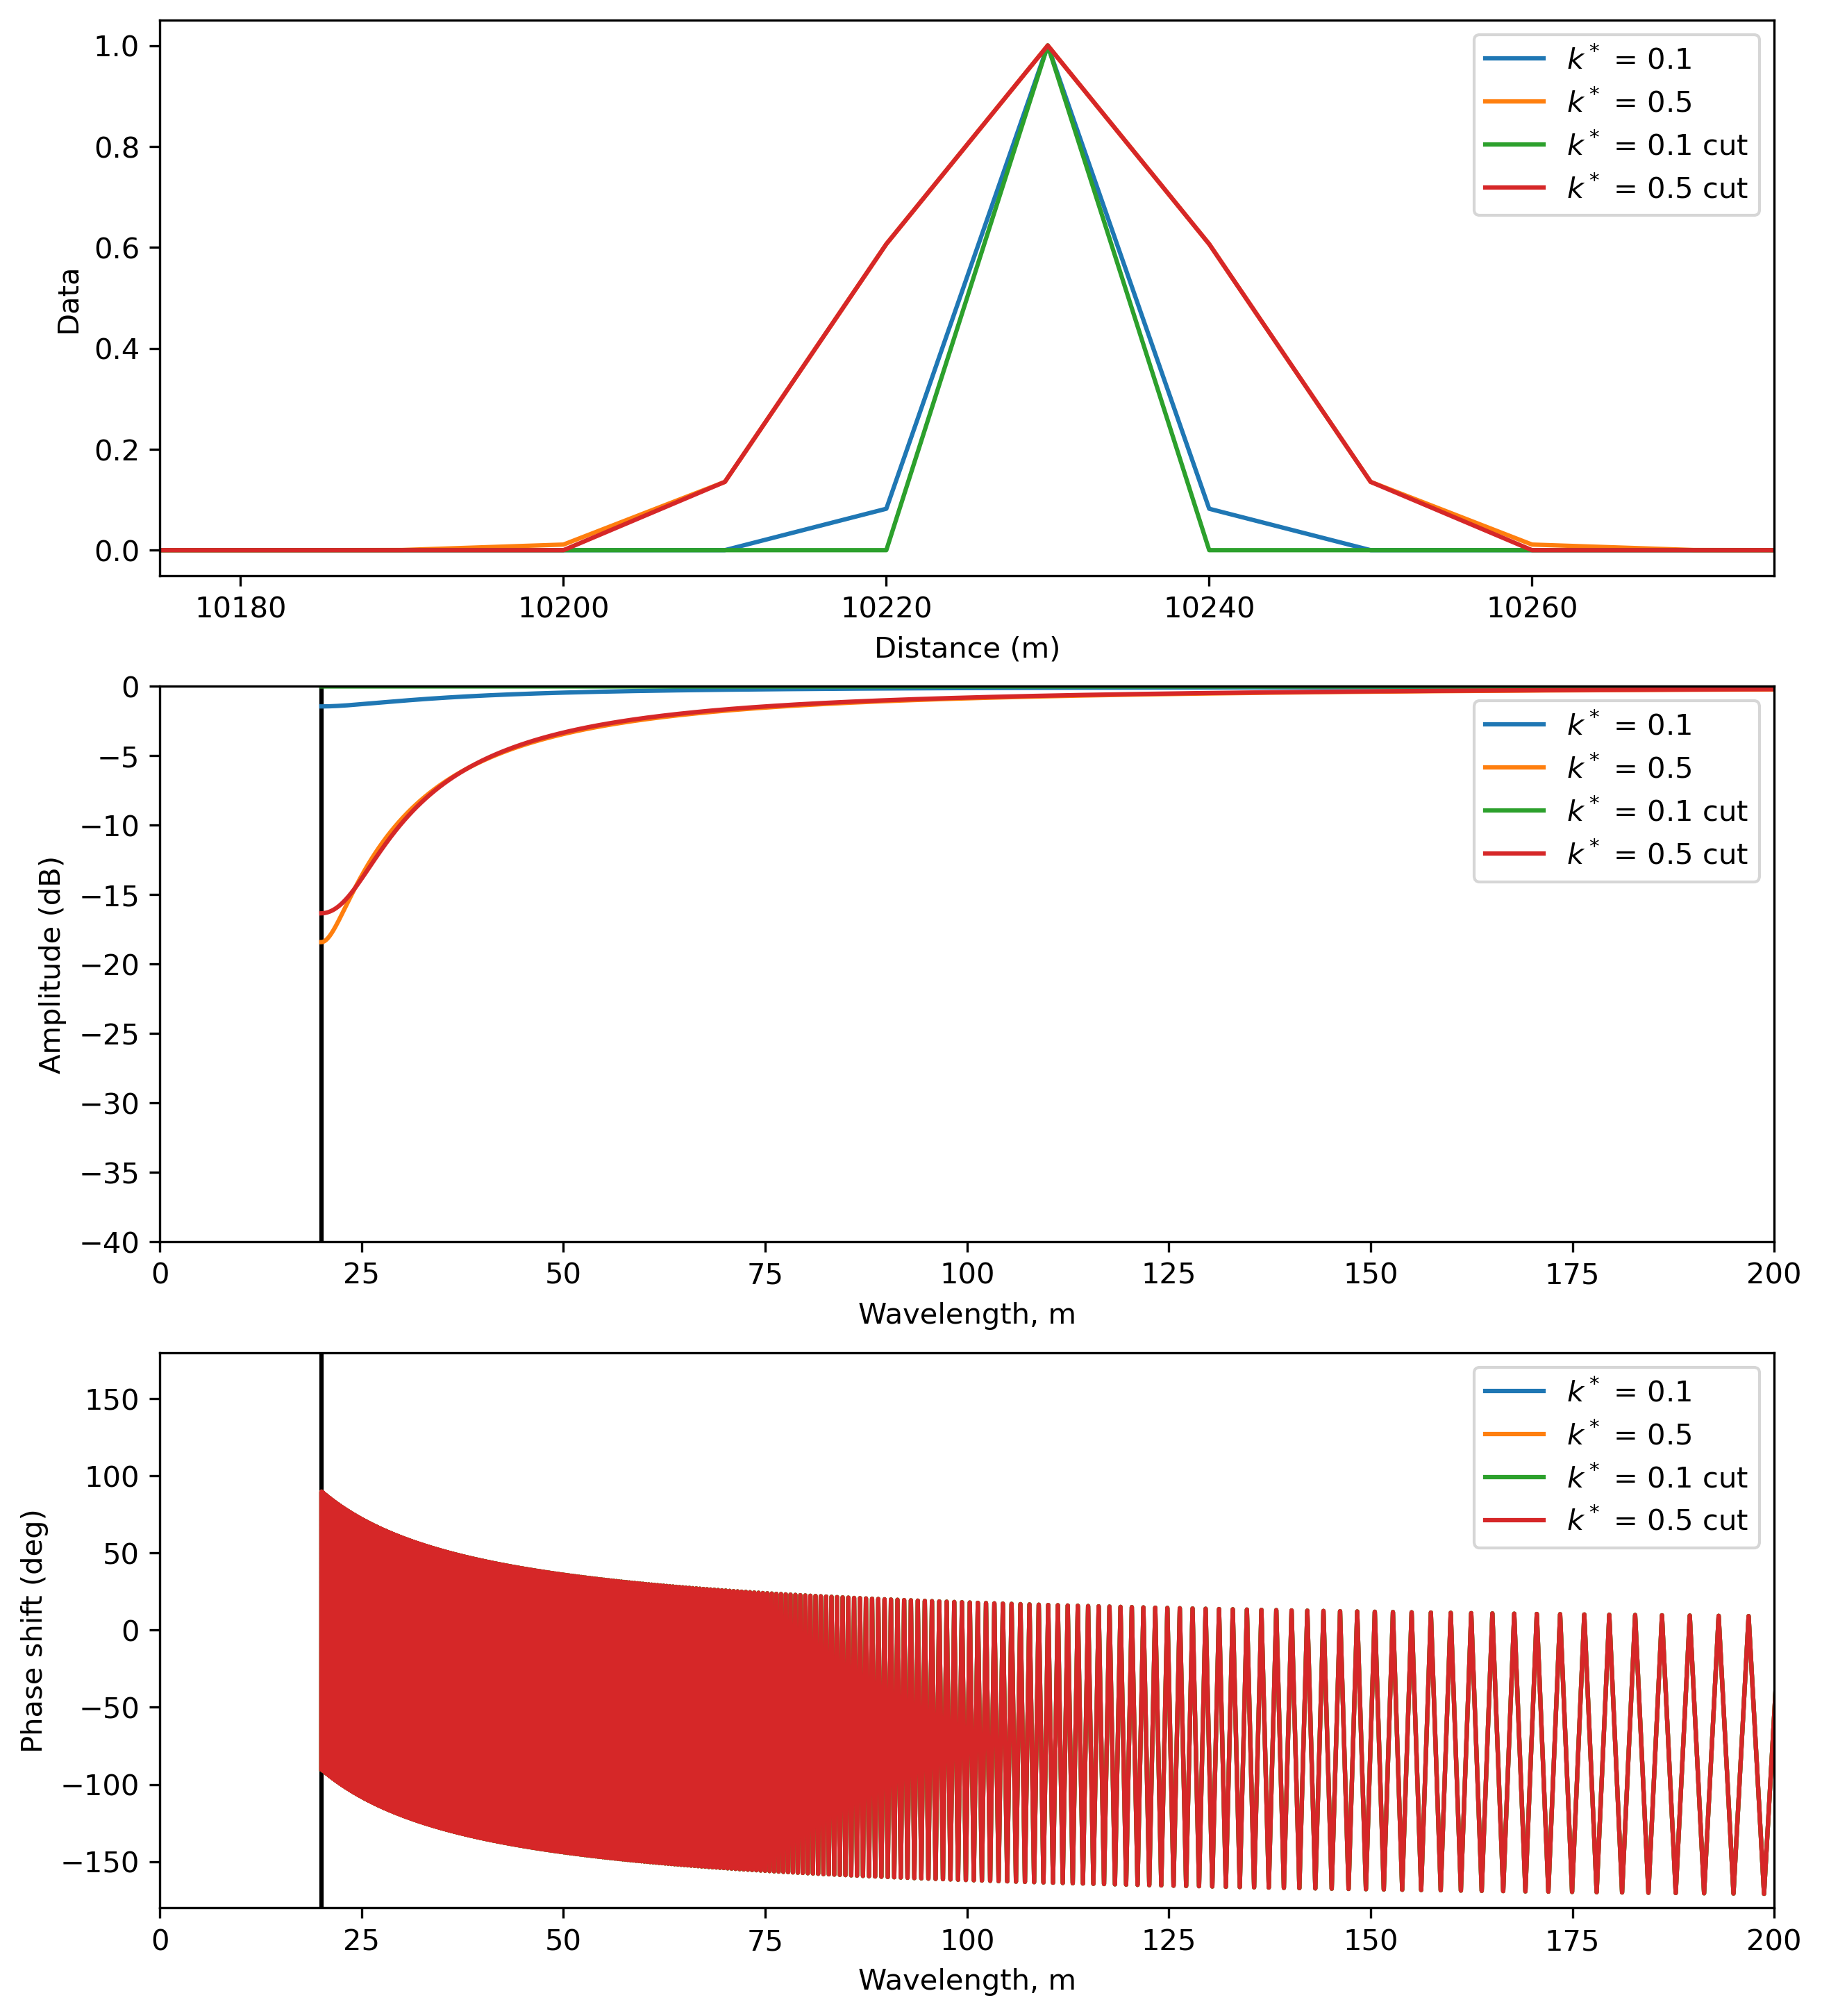

In [309]:
from scipy.signal.windows import gaussian

# Setting the values for k*
k1 = 0.1
k5 = 0.5

# Calculating the standard deviation
sig_1 = np.sqrt(2 * k1)
sig_5 = np.sqrt(2 * k5)

# Calculating the gaussian weight function
gaussian_1 = gaussian(N,sig_1)
gaussian_5 = gaussian(N,sig_5)

# Cutting off values below 0.1
gaussian_1_cut = np.where(gaussian_1 < 0.1,0,gaussian_1)
gaussian_5_cut = np.where(gaussian_5 < 0.1,0,gaussian_5)

# Plotting the figures
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

gaussian_weights = [gaussian_1, gaussian_5, gaussian_1_cut, gaussian_5_cut]
labels = ['$k^*$ = 0.1', '$k^*$ = 0.5', '$k^*$ = 0.1 cut','$k^*$ = 0.5 cut']

response_plot(gaussian_weights[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(10175,10275)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**4.** Implement and plot the frequency response for 3- and 5-point rectangular weight (boxcar) functions.

-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

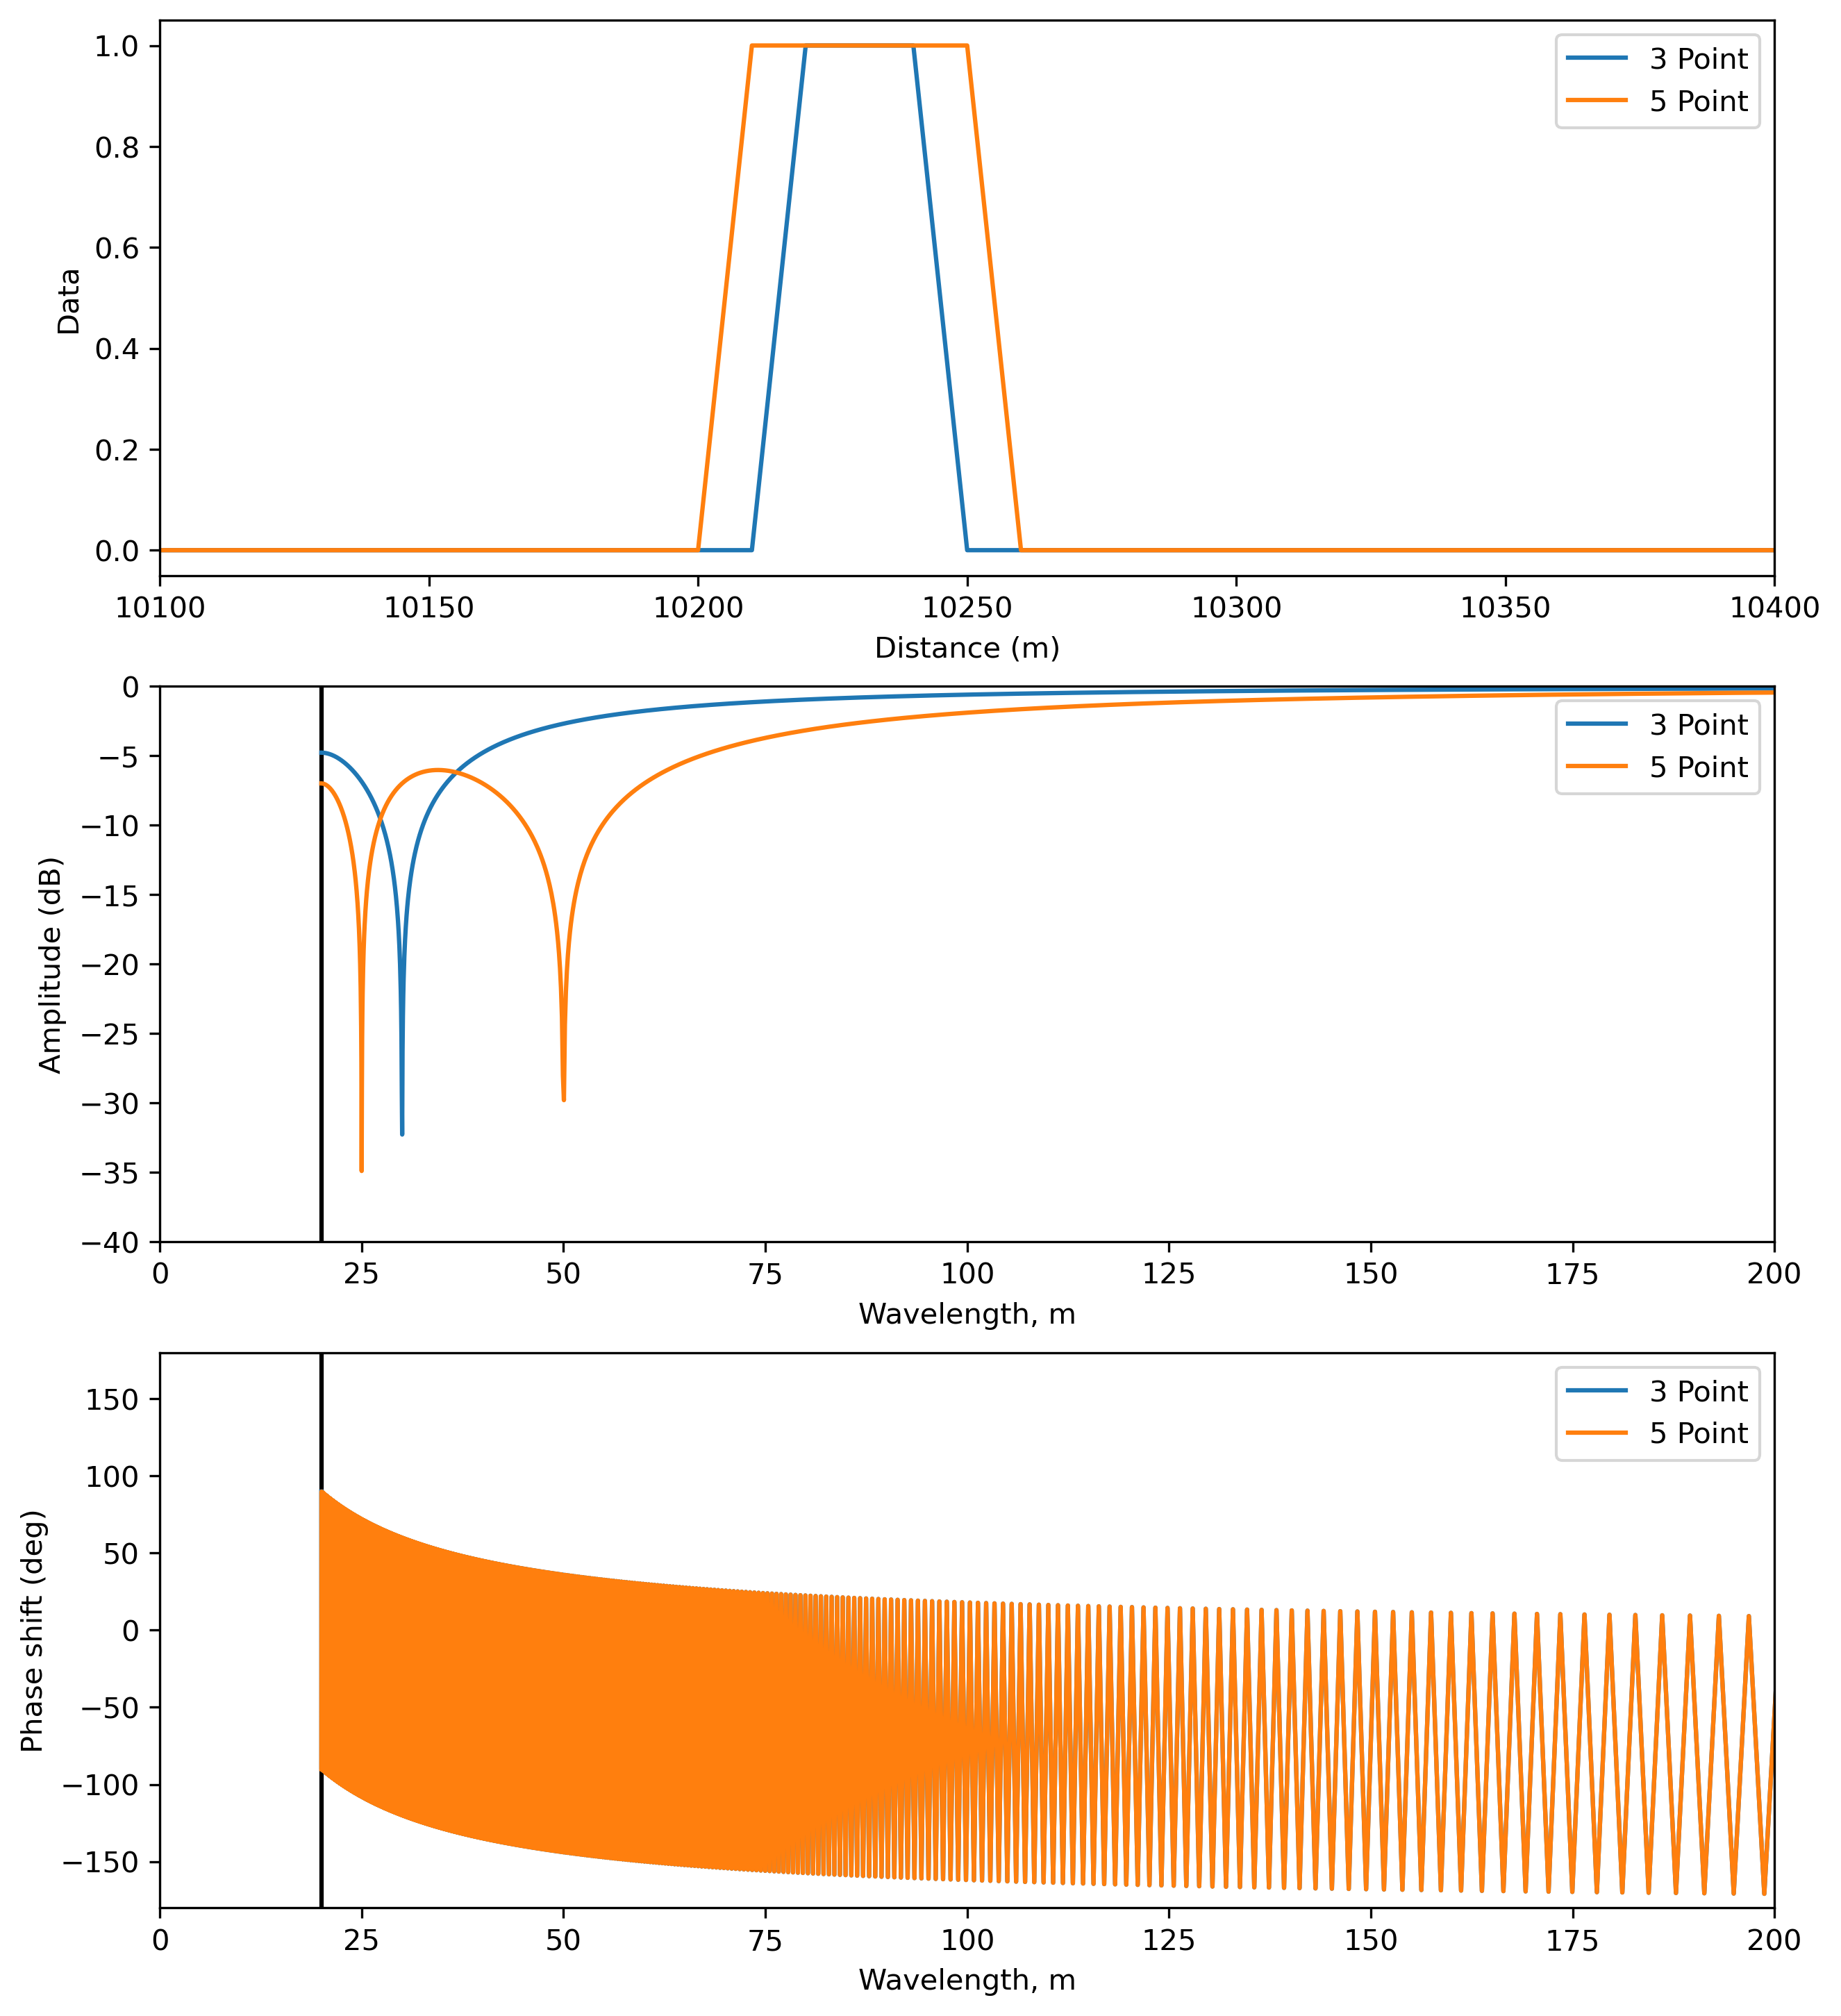

In [310]:
# your code here
from scipy.signal.windows import boxcar

# Calculating the boxcar
boxcar_3 = boxcar(N)
boxcar_5 = boxcar(N)

# Calculating the boxcar for three point and then centering it
center3 = int(len(boxcar_3)/2)

boxcar_arr_1 = np.array(boxcar_3)
boxcar_arr_1[0:center3-1] = 0
boxcar_arr_1[center3+2:] = 0

# Calculating the boxcar for the five point function then centering it
center5 = int(len(boxcar_5)/2)

boxcar_arr_5 = np.array(boxcar_5)
boxcar_arr_5[0:center5-2] = 0
boxcar_arr_5[center5+3:] = 0


# Plotting the figures
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

boxcar_weights = [boxcar_arr_1, boxcar_arr_5]
labels = ['3 Point', '5 Point']

response_plot(boxcar_weights[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(10100,10400)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**5.** Implement and plot a 5-point Parzen (Riesz) weight function. Also show the effect of an artifical cutoff by removing the weights below 0.1.

<span class="ecb">You've essentially created one boxcar window here, and then a very wide cutoff Parzen one that is much wider than five points. -6</span>

<span class="ecb">Per data point, parmesan weight tends to be high, as it's a dense cheese!</span>

-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

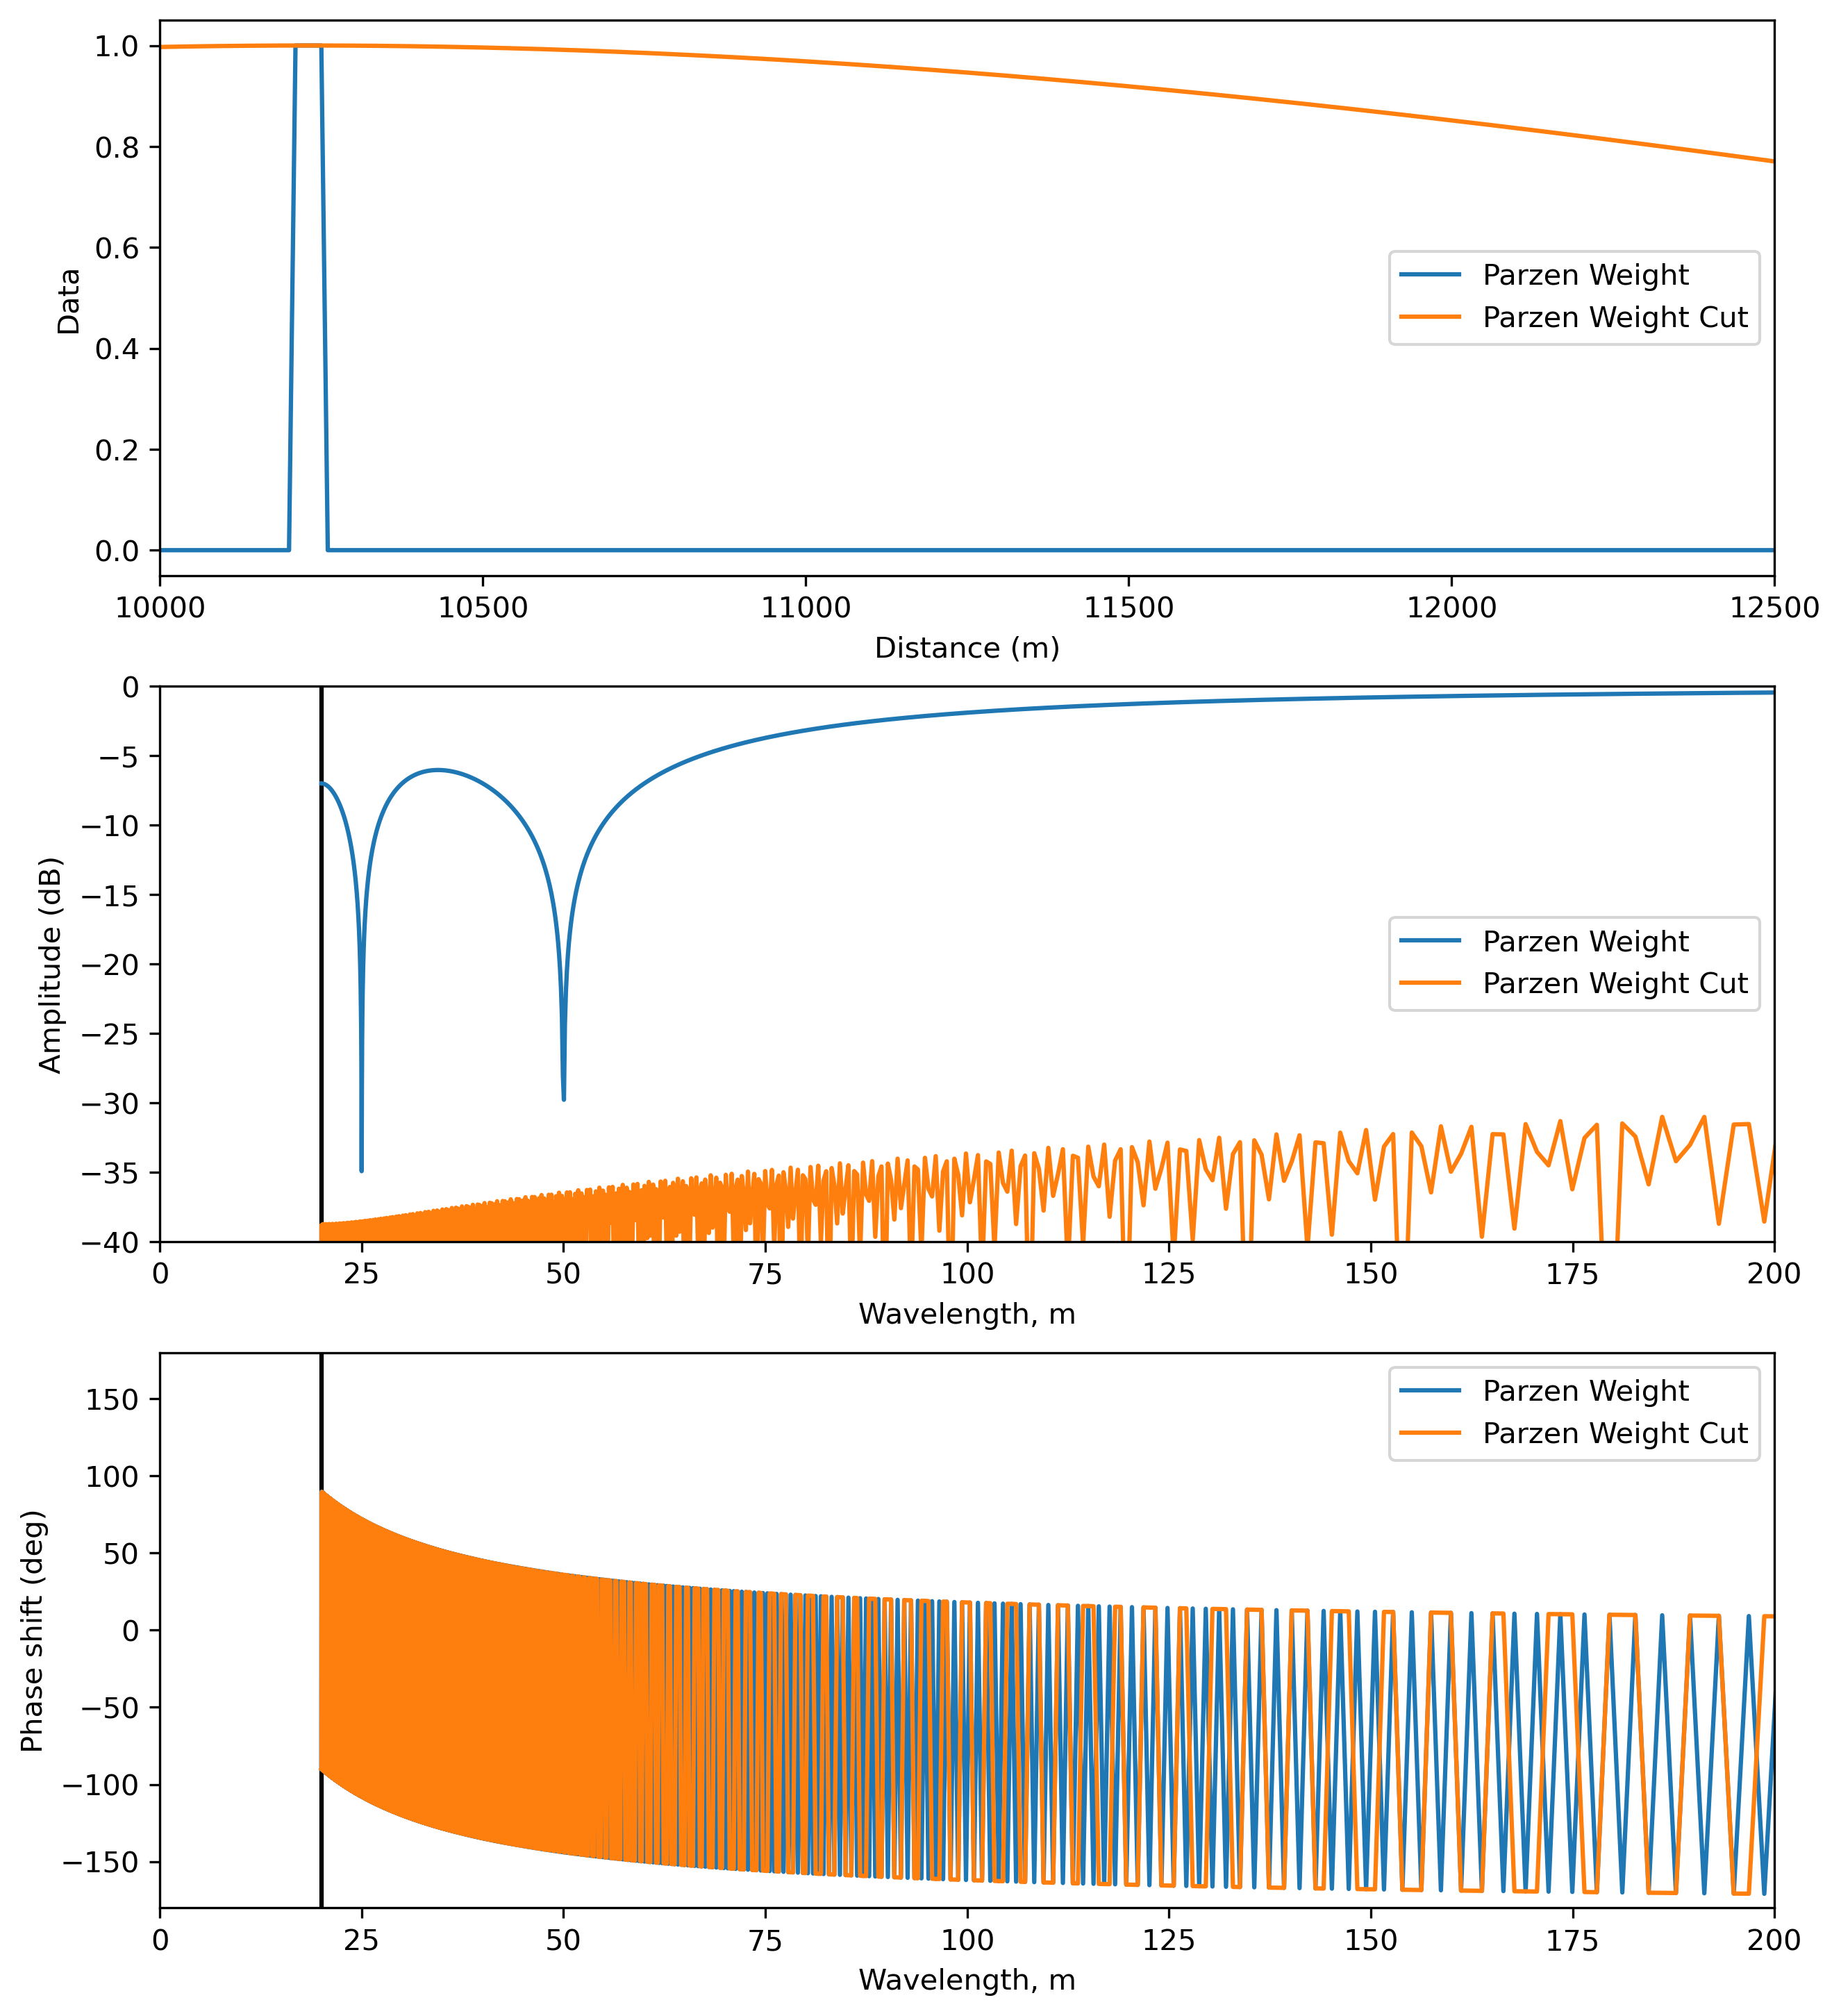

In [311]:
from scipy.signal.windows import parzen

parmesan_weight = parzen(N)
center_parmesan = int(len(parmesan_weight)/2)
parmesan_arr_5 = np.array(parmesan_weight)
parmesan_arr_5[0:center_parmesan-2] = 0
parmesan_arr_5[center_parmesan+3:] = 0

parzen_weight_cut = np.where(parmesan_weight < 0.1,0,parmesan_weight)


fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

parzen_weights = [parmesan_arr_5, parzen_weight_cut]
labels = ['Parzen Weight', 'Parzen Weight Cut']

response_plot(parzen_weights[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(10000,12500)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**6.** Implement and plot a 5-point Dolph-Chebyshev weight function with a lowest sidelobe level of 60 dB. Also show the effect of an artifical cutoff by removing the weights below 0.1.

<span class="ecb">You've essentially created one boxcar window here, and then a very wide cutoff D-C one that is much wider than five points. -6</span>

-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

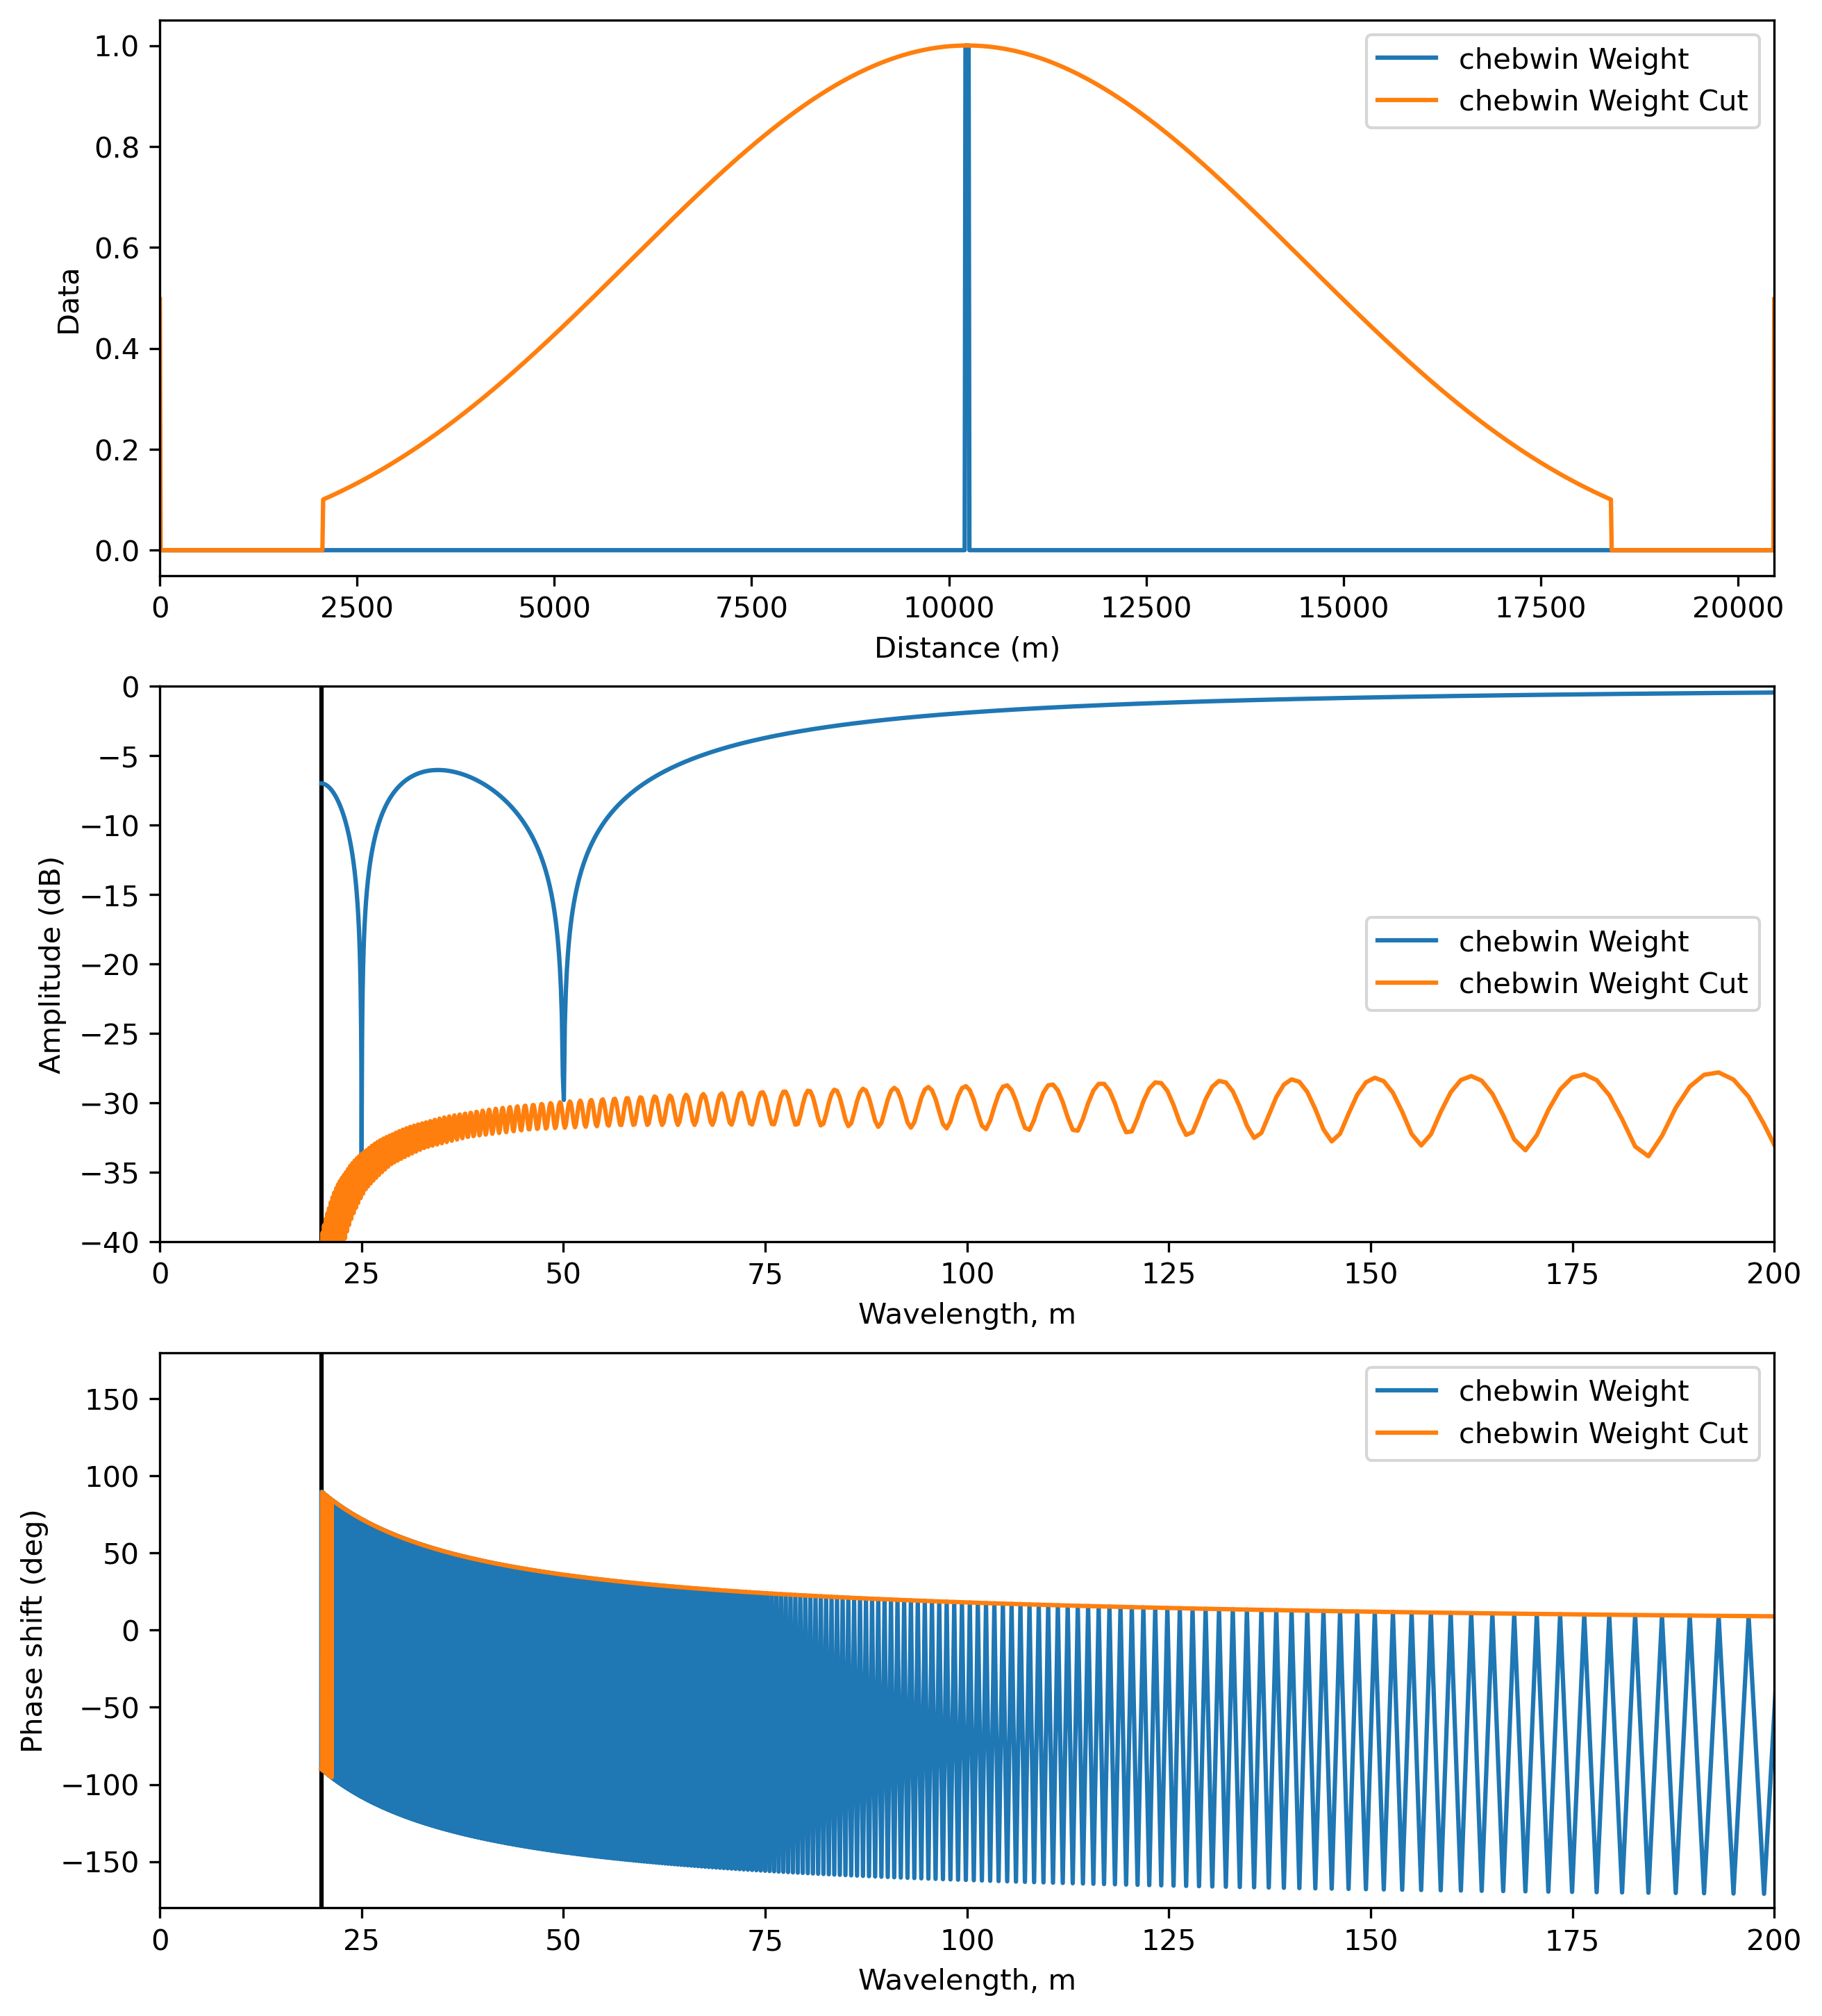

In [313]:
from scipy.signal.windows import chebwin

chebwin_weight = chebwin(N,60)
center_chebwin = int(len(chebwin_weight)/2)
chebwin_arr_5 = np.array(chebwin_weight)
chebwin_arr_5[0:center_chebwin-2] = 0
chebwin_arr_5[center_chebwin+3:] = 0

chebwin_weight_cut = np.where(chebwin_weight < 0.1,0,chebwin_weight)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

chebwin_weights = [chebwin_arr_5, chebwin_weight_cut]
labels = ['chebwin Weight', 'chebwin Weight Cut']

response_plot(chebwin_weights[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**7.** Implement and plot a 7-point Blackman and a 7-point Blackman-Harris weight function. There is no need to show the effect of an artificial cutoff here.

<span class="ecb">You've essentially created two identical boxcar windows here, after starting with an N-point window that is essentially flat across the first five or seven points centered on the peak of the Blackman or BH windows. -8</span>

-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

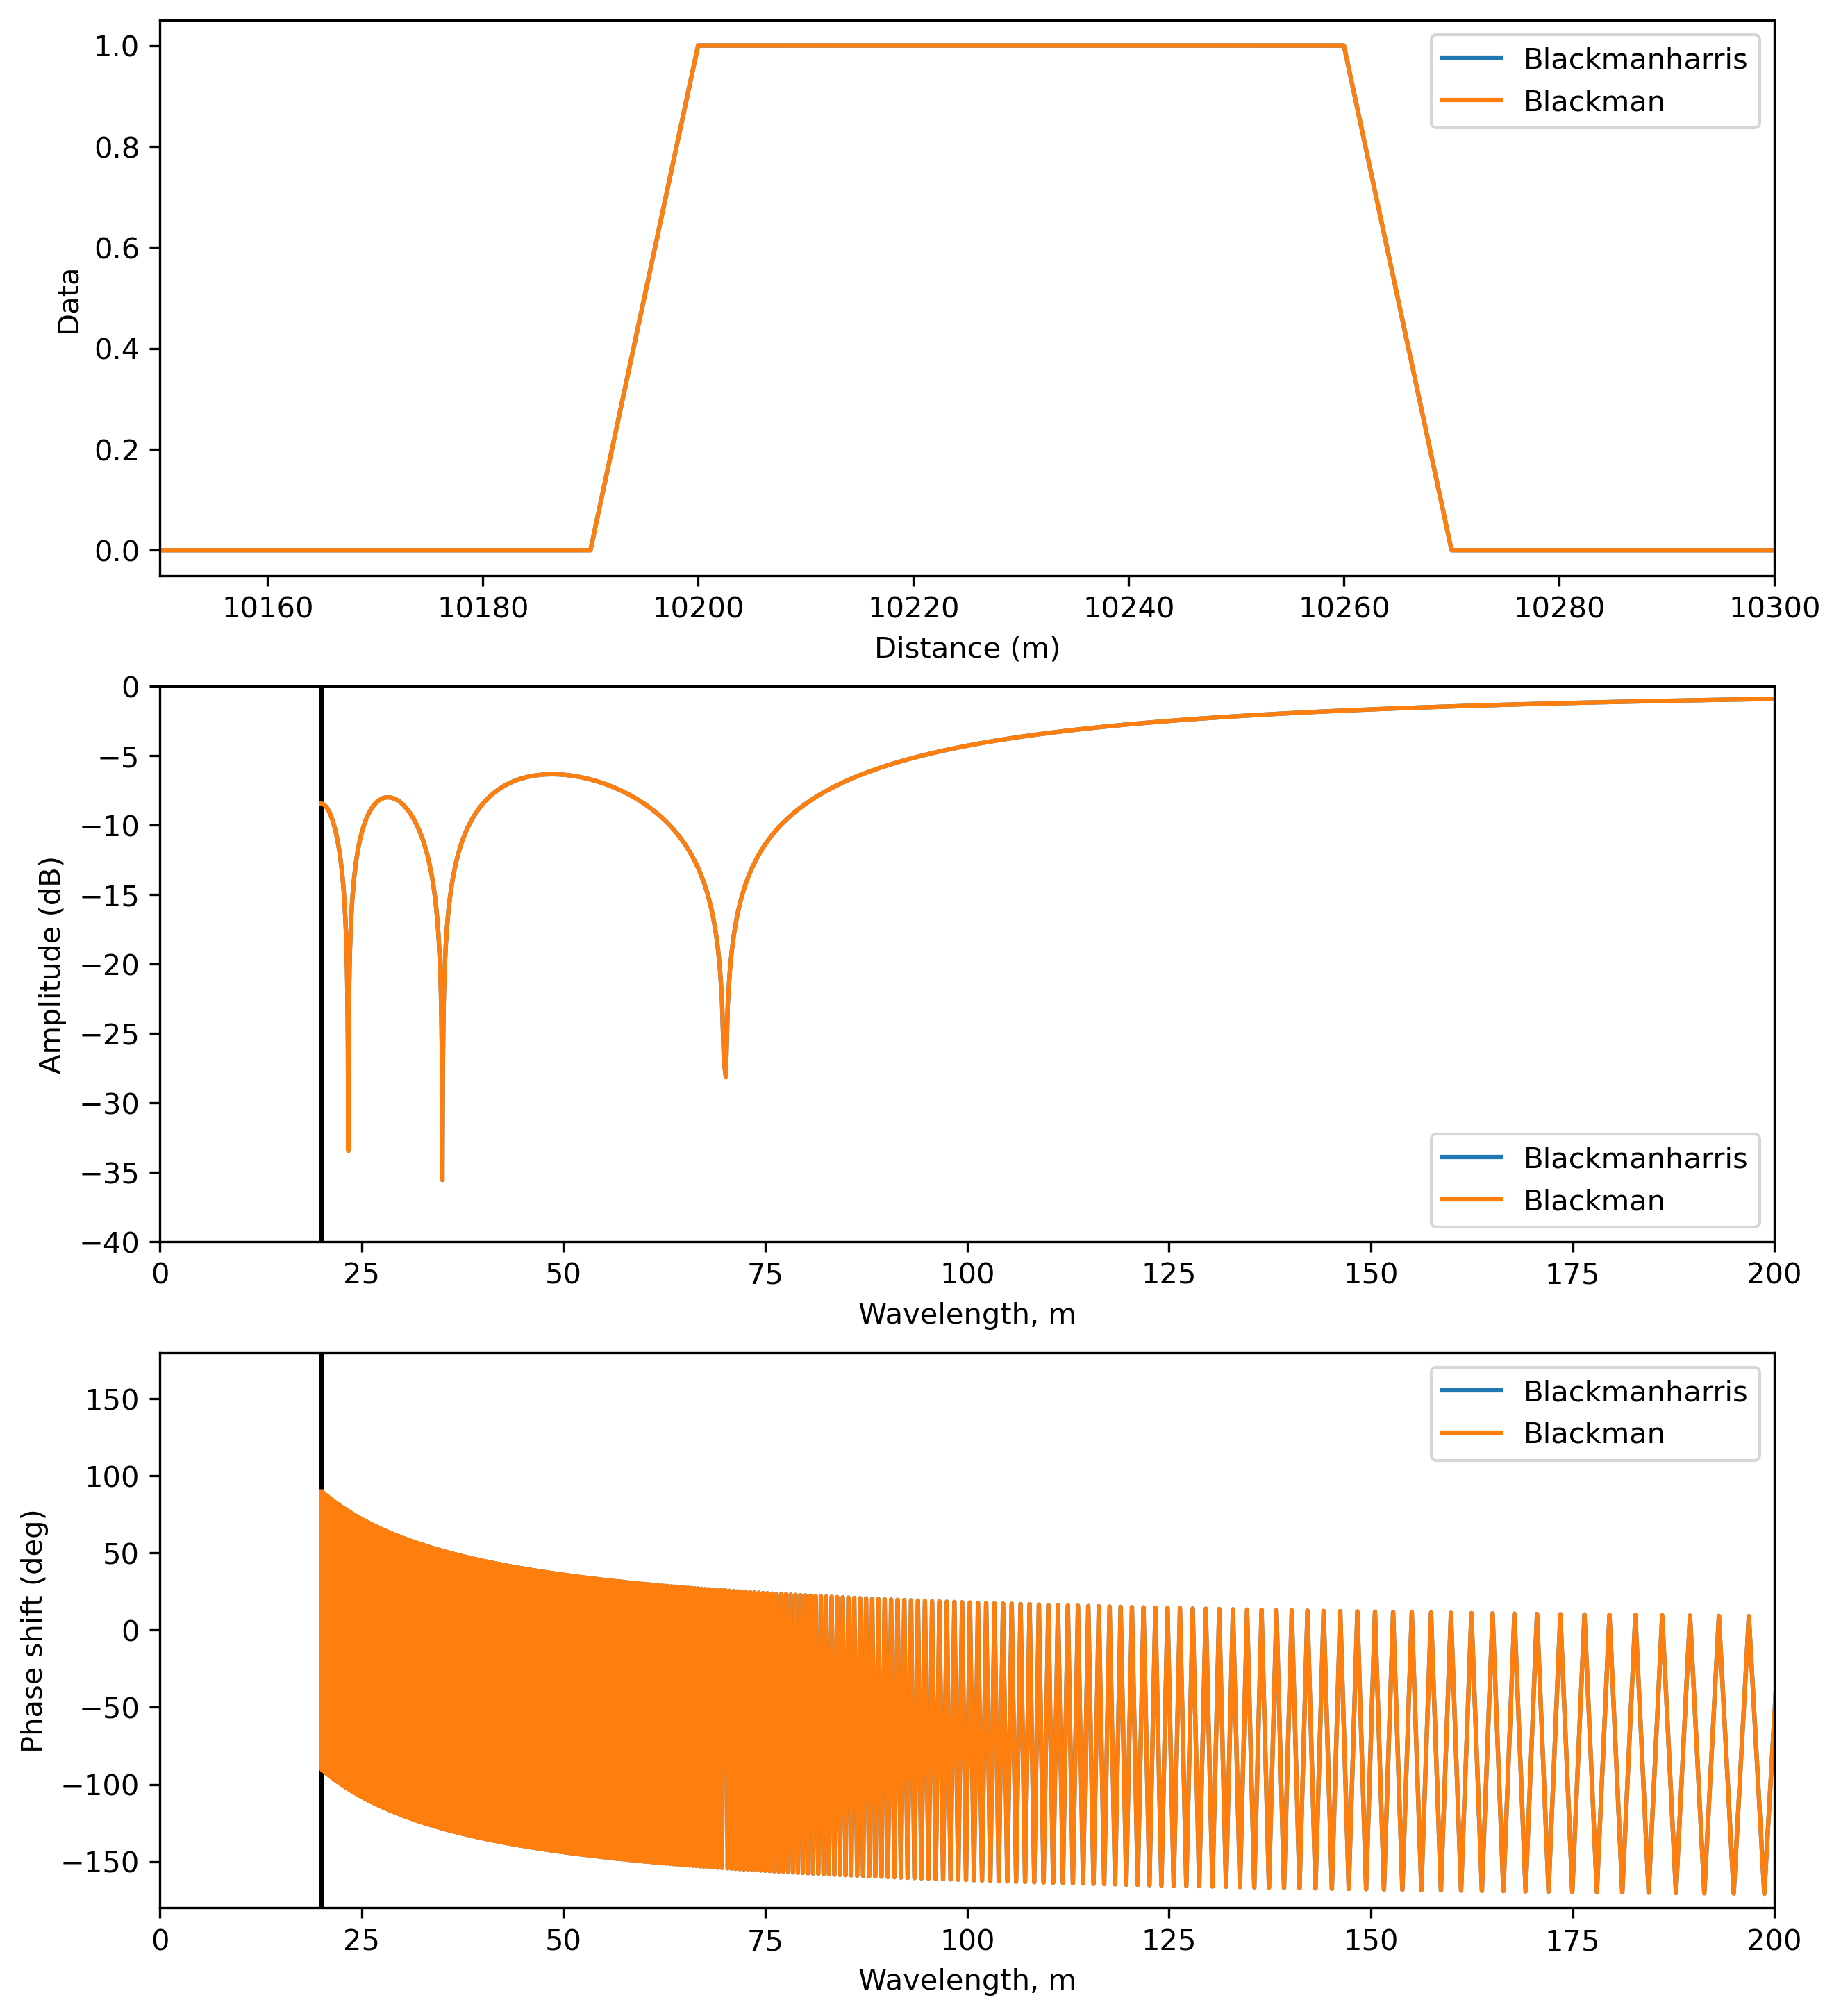

In [261]:
from scipy.signal.windows import blackmanharris, blackman

# For the blackmanharris
blackmanharris_weight = blackmanharris(N)
blackmanharris_center = int(len(blackmanharris_weight)/2)
blackmanharris_arr_5 = np.array(blackmanharris_weight)
blackmanharris_arr_5[0:blackmanharris_center-3] = 0
blackmanharris_arr_5[blackmanharris_center+4:] = 0

# for the blackman
blackman_weight = blackman(N)
blackman_center = int(len(blackman_weight)/2)
blackman_arr_5 = np.array(blackman_weight)
blackman_arr_5[0:blackman_center-3] = 0
blackman_arr_5[blackman_center+4:] = 0

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

b_weights = [blackmanharris_arr_5, blackman_arr_5]
labels = ['Blackmanharris', 'Blackman']

response_plot(b_weights[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(10150,10300)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**8.** 

**a.** Plot all weight functions together on the same graph, excluding those that show the effect of an artificial cutoff. Use  `dB_amp=False` to show the amplitude response in linear units.

**b.** Assume our critiera for a best analysis ranks our priorties as follows:
1. Smooth frequency response
2. Minimum amplitude at the Nyquist
3. Maximum amplitude at relatively small wavelengths just next to the Nyquist

Which weight functions are worst by these critera?

Which weight function do you regard as best, and why?

**c.** Compare the Nyquist-crossing amplitudes of the two Gaussian weight functions to the values in Koch et al. (1983), Fig. 1. How does each crossing point differ? What is the reason for the differences?

-20470.0 20470.0


<ipython-input-35-4aed02b7edbe>:25: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

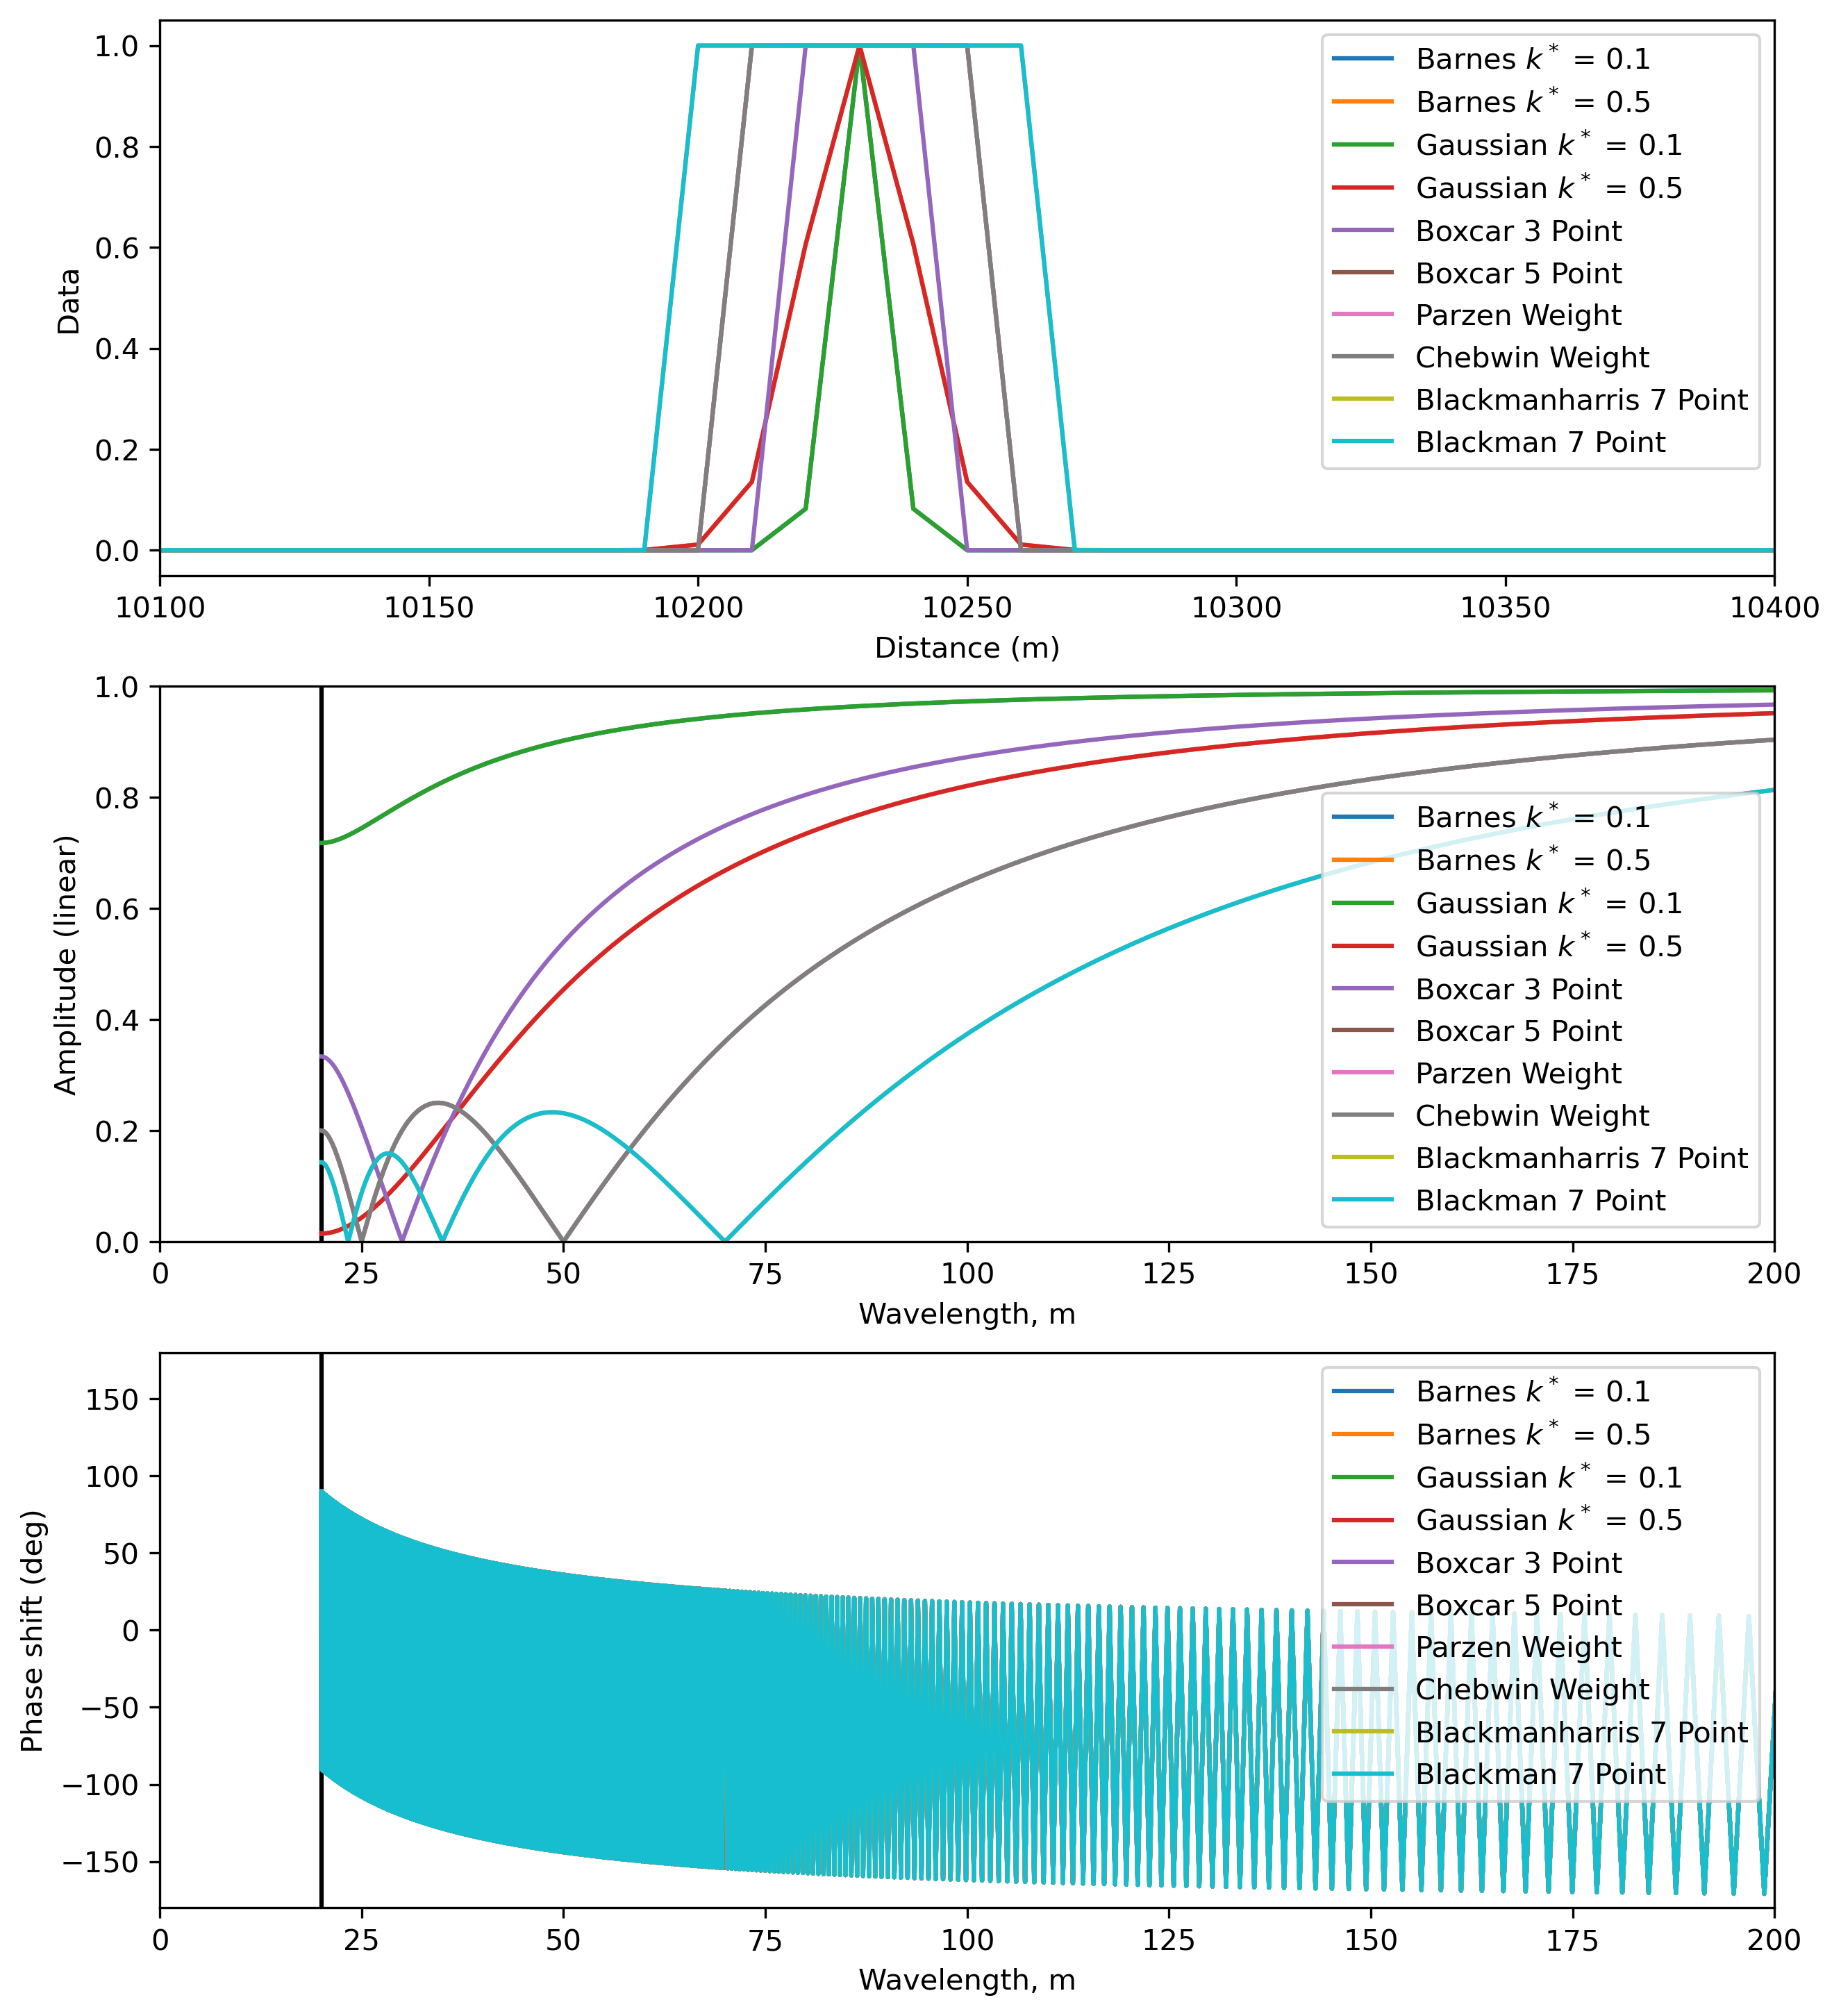

In [287]:
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

all_weights = [weight_1, weight_5, gaussian_1, gaussian_5, boxcar_arr_1, boxcar_arr_5, parmesan_arr_5, chebwin_arr_5, 
               blackmanharris_arr_5, blackman_arr_5]
labels = ['Barnes $k^*$ = 0.1', 'Barnes $k^*$ = 0.5', 'Gaussian $k^*$ = 0.1', 'Gaussian $k^*$ = 0.5', 'Boxcar 3 Point', 
          'Boxcar 5 Point', 'Parzen Weight', 'Chebwin Weight', 'Blackmanharris 7 Point', 'Blackman 7 Point']

response_plot(all_weights[:], x, axes, freqs, labels=labels[:], wavelength=True,dB_amp=False)
axes[0].set_xlim(10100,10400)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**b. The worst is the the barnes at 0.1 and 0.5. I chose these both because they had very similar characteristics that can be seen on the graphs. For the frequency responce, there are other graphs that contain the same shape, but their amplitude stands out to be the clear worst. At the nyquist, they have by far the highest amplitude of all of the functions. The best is the gaussian at 0.5 based on its relativiley smoothest frequency responce and the best amplitude as defined by the criteria of points one and two. Based on this criteria, a blackman 7 point weighting would probally be the second.**

***c. The figure as a whole shows how that using a smaller weight parameter yields in a greater responce in filter when the data is passed through. The function at k* = 0.1 have a responce frequency of around 0.5, and 0.05 for k = 0.5. Thus k = 0.1 is has has a much higher responce than that of 0.5. One reason that they may differ is that is k the determinate of how the shape of the curve is, a certain k can resolve data differently depending on the data distribution. So maybe the spatial scale, or our delta, is defined differently.***

<span class="ecb">For b., Barnes and Guassian at 0.5 are the same, but you said one was best and the other worst. -2. For c., the difference is that we used a discrete FT, and this undersamples the shape of the curve and brings the amplitude close to 1 since it's closer to a delta function in space. -2</span>